In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [19]:
loss_tracker = keras.metrics.Mean(name="loss")

class Funsol(keras.Model):
    @property
    def metrics(self):
        return [loss_tracker] # define como llamar a la metrica en model.fit(metrics)

    def train_step(self, data):
        batch_size = 10
        x = tf.random.uniform((batch_size, ), minval=-1, maxval=1)
        y = 3*tf.math.sin(math.pi*x)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = keras.losses.mean_squared_error(y_pred, y)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss)   # actualiza metricas

        return {"loss": loss_tracker.result()}

In [20]:
class SinTransform(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super().__init__()
        self.num_outputs = num_outputs
        self.freq = tf.range(1., self.num_outputs + 1)
        self.kernel = self.add_weight("kernel", shape=[self.num_outputs])

    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs)
        
        if (inputs.shape == ()):
            inputs=(inputs, )
        elif (len(inputs.shape) == 1):
            inputs = tf.expand_dims(inputs, axis=1)
            
        batch = tf.shape(inputs)[0]
        self.freq_b = tf.ones([batch, 1])*self.freq
        args = self.freq_b * inputs
        modes = tf.math.sin(args)
        return tf.tensordot(modes, self.kernel, 1)

In [21]:
# just to see that the layer works, still not training anything
trans_layer = SinTransform(1)
x = tf.random.uniform([5], minval=-1., maxval=1.)
print(x)
result = trans_layer(x)
print(result)

tf.Tensor([-0.0064919   0.14043713  0.7627785   0.28410792  0.5371151 ], shape=(5,), dtype=float32)
tf.Tensor([ 0.00381032 -0.08215732 -0.40553528 -0.1645197  -0.30031282], shape=(5,), dtype=float32)


In [22]:
# model definition
inputs = keras.Input((1,))
x = SinTransform(6)(inputs)
model = Funsol(inputs, x)
model.summary()

Model: "funsol_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 sin_transform_8 (SinTransf  (None,)                   6         
 orm)                                                            
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# train data
x_train = tf.linspace(-1, 1, 100)

In [26]:
# training
model.compile(optimizer="SGD", metrics=["loss"])
history = model.fit(x_train, epochs=50, verbose=2)
model.save('sin.hdf5')

Epoch 1/50
4/4 - 0s - loss: 0.0246 - 155ms/epoch - 39ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0450 - 5ms/epoch - 1ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0326 - 7ms/epoch - 2ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0475 - 7ms/epoch - 2ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0201 - 7ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0320 - 7ms/epoch - 2ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0371 - 6ms/epoch - 2ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0281 - 7ms/epoch - 2ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0310 - 5ms/epoch - 1ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0355 - 6ms/epoch - 1ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0301 - 6ms/epoch - 1ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0302 - 5ms/epoch - 1ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0226 - 6ms/epoch - 1ms/step
Epoch 14/50
4/4 - 0s - loss: 0.0111 - 5ms/epoch - 1ms/step
Epoch 15/50
4/4 - 0s - loss: 0.0239 - 5ms/epoch - 1ms/step
Epoch 16/50
4/4 - 0s - loss: 0.0176 - 6ms/epoch - 1ms/step
Epoch 17/50
4/4 - 0s - loss: 0.0207 - 5ms/epoch - 1ms/step
Epo

/home/dynamix/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 2ms/step


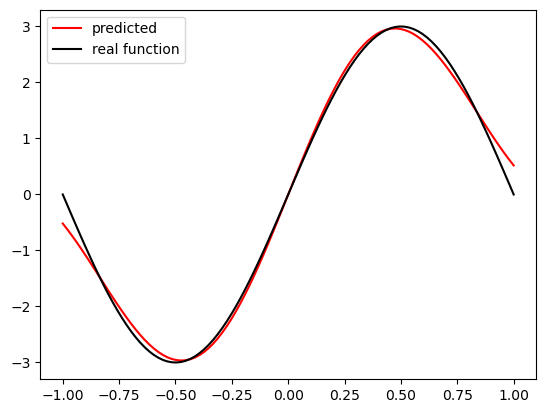

In [27]:
x_test = tf.linspace(-1, 1, 100)
predictions = model.predict(x_test)
plt.plot(x_test, predictions, color="red", label='predicted')
plt.plot(x_test, 3*tf.math.sin(math.pi*x_test), color="black", label='real function')
plt.legend()
plt.show()